# Monte Carlo
## On-policy first-visit MC control (for epsilon-soft policies)

- Rodolfo Vasconcelos

SCS 3547 – Intelligent Agents & Reinforcement Learning

UNIVERSITY OF TORONTO - SCHOOL OF CONTINUING STUDIES

Instructor: Larry Simon


## About the Project
Implementation of the algorithm given on Chapter 5.4, page 101 of Sutton & Barton's book "Reinforcement Learning: An Intruduction", which is the On-policy first-visit Mont Carlo control (for epsilon-soft policies).

![On-policy first-visit MC control](https://raw.githubusercontent.com/ravasconcelos/monte_carlo/master/images/onpolicy_firstvisit_MC_esoft.png)

This algorithm to find an approximation of the optimal policy for the gridworld on page 76 and 77 of the book above.

![Optimal Policy](https://raw.githubusercontent.com/ravasconcelos/monte_carlo/master/images/optimal_policy.png)

This notebook prints as output a table of the estimated q function Q(s,a) for the optimal policy and the optimal policy itself.

**Note**: this code was based on the Lazy Programmer's code.

# Algorithm
This Monte Carlo algorithm produces n episodes starting from random points of the grid, and let the agent move to the four directions according to the epsilon-soft policy until a termination state is achieved. 

For each episode we save the 4 values: (1) the initial state, (2) the action taken, (3) the reward received and (4) the final state. 

In the end, a episode is just an array containing x arrays of these values, x being the number of steps the agent had to take until reaching a terminal state.

From these episodes, we iterate from the end of the “experience” array, and compute G as the previous state value in the same experience (weighed by gamma, the discount factor) plus the received reward in that state. 

For each pair St,At that is not in the experience array:
* append G in an array of Returns(St,At)
* compute the Q(St,At) as the average of the Returns(St,At)
* get the action for the max Q(St,At)
* update the pi(a|St)

pi(a|St) contais the probalities an action can be chosen for a given state.Changing the epsilon we can change the probability the agent will be able to explore other actions insteady of choosing the best action.

## Constants
A good approximation of the best policy can be found with:
* Number of episodes: 5000
* Gamma=0.6
* Epsilon=0.3

Or:
* Number of episodes: 10000
* Gamma=0.9
* Epsilon=0.3


In [1]:
EPISODES = 5000 # number of episodes
GAMMA = 0.6
EPS = 0.4
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

## Imports

In [2]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## Print functions

In [3]:
def print_Q(Q, grid):
    print('----------------------------------------------')
    print('| State  | U      | D      | L      | R      |')
    print('----------------------------------------------')
    all_states = sorted(grid.all_states())
    for state in all_states:
        print("| {} |".format(state), end="")
        if state != (0,0) and state != (3,3):
            for action, value in Q[state].items():
                print(' {:>6.2f} |'.format(value), end="")
        else:
            print('   0.00 |   0.00 |   0.00 |   0.00 |',end="")
        print('')
    print('----------------------------------------------')

def print_values(V, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")

def print_policy(P, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")


## Grid World

In [4]:
class Grid: # Environment
  def __init__(self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  
  def move(self, action):
    # check if legal move first
    #print('before i={} j={} action={}'.format(self.i,self.j,action))
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    # return a reward (if any)
    #return self.rewards.get((self.i, self.j), 0)
    reward = self.rewards.get((self.i, self.j), 0)
    #print('after i={} j={} r={}'.format(self.i,self.j,reward))
    return reward

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # S means start position
  # E means the end states
  #
  # E  .  .  .
  # .  .  . .
  # S  .  .  .
  # .  .  .  E
  g = Grid(4, 4, (2, 0))
  rewards = {(0, 0): 0, (3, 3): 0}
  actions = {
    #(0, 0): (), End-State
    (0, 1): ('D', 'R', 'L'),
    (0, 2): ('D', 'R', 'L'),
    (0, 3): ('D', 'L'),
    (1, 0): ('D', 'R', 'U'),
    (1, 1): ('D', 'R', 'L', 'U'),
    (1, 2): ('D', 'R', 'L', 'U'),
    (1, 3): ('D', 'U', 'L'),
    (2, 0): ('D', 'U', 'R'),
    (2, 1): ('D', 'R', 'L', 'U'),
    (2, 2): ('D', 'R', 'L', 'U'),
    (2, 3): ('D', 'U', 'L'),
    (3, 0): ('U', 'R', ),
    (3, 1): ('U', 'R', 'L'),
    (3, 2): ('U', 'R', 'L'),
    #(3, 3): (), End-State
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 1): step_cost,
    (0, 2): step_cost,
    (0, 3): step_cost,
    (1, 0): step_cost,
    (1, 1): step_cost,
    (1, 2): step_cost,
    (1, 3): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
    (3, 0): step_cost,
    (3, 1): step_cost,
    (3, 2): step_cost,
  })
  return g

## pi functions

In [5]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val


def policy_using_pi(St, pi):
    return np.random.choice(ALL_POSSIBLE_ACTIONS, p=[pi[(St,a)] for a in ALL_POSSIBLE_ACTIONS])

## Episode functions

In [6]:
def play_episode(grid, policy, pi):
  # returns a list of states and corresponding returns
  # in this version we will NOT use "exploring starts" method
  # instead we will explore using an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = policy_using_pi(s,pi)

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy_using_pi(s,pi)
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns


## Run all episodes

In [7]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
# grid = standard_grid()
# try the negative grid too, to see if agent will learn to go past the "bad spot"
# in order to minimize number of steps
grid = negative_grid(step_cost=-1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))  # probability of action (def random)

# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = -10
        returns[(s,a)] = []
else:
    # terminal state or state we can't otherwise get to
    pass

#print("initial Q:")
#print_Q(Q,grid)

# repeat until convergence
deltas = []
for t in range(EPISODES):
    if t % 1000 == 0:
        print(t)
        print("Q:")
        print_Q(Q,grid)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_episode(grid, policy, pi)

    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        sa = (s, a)
        if sa not in seen_state_action_pairs:
            old_q = Q[s][a]
            returns[sa].append(G)
            Q[s][a] = np.mean(returns[sa])
            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
            seen_state_action_pairs.add(sa)
            A_star, _ = max_dict(Q[s])
            for a_index in ALL_POSSIBLE_ACTIONS:
                if a_index == A_star:   pi[(s,a_index)] = 1 - EPS + EPS/len(ALL_POSSIBLE_ACTIONS)
                else:                   pi[(s,a_index)] = EPS/len(ALL_POSSIBLE_ACTIONS)

    deltas.append(biggest_change)

    # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
    for s in policy.keys():
        a, _ = max_dict(Q[s])
        policy[s] = a



rewards:
---------------------------
 0.00|-1.00|-1.00|-1.00|
---------------------------
-1.00|-1.00|-1.00|-1.00|
---------------------------
-1.00|-1.00|-1.00|-1.00|
---------------------------
-1.00|-1.00|-1.00| 0.00|
0
Q:
----------------------------------------------
| State  | U      | D      | L      | R      |
----------------------------------------------
| (0, 0) |   0.00 |   0.00 |   0.00 |   0.00 |
| (0, 1) | -10.00 | -10.00 | -10.00 | -10.00 |
| (0, 2) | -10.00 | -10.00 | -10.00 | -10.00 |
| (0, 3) | -10.00 | -10.00 | -10.00 | -10.00 |
| (1, 0) | -10.00 | -10.00 | -10.00 | -10.00 |
| (1, 1) | -10.00 | -10.00 | -10.00 | -10.00 |
| (1, 2) | -10.00 | -10.00 | -10.00 | -10.00 |
| (1, 3) | -10.00 | -10.00 | -10.00 | -10.00 |
| (2, 0) | -10.00 | -10.00 | -10.00 | -10.00 |
| (2, 1) | -10.00 | -10.00 | -10.00 | -10.00 |
| (2, 2) | -10.00 | -10.00 | -10.00 | -10.00 |
| (2, 3) | -10.00 | -10.00 | -10.00 | -10.00 |
| (3, 0) | -10.00 | -10.00 | -10.00 | -10.00 |
| (3, 1) | -10.00 | -1

## Print results

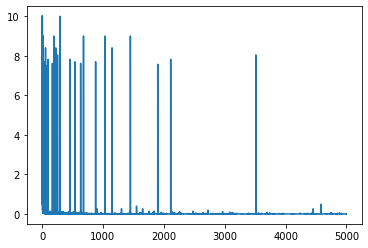

final values:
---------------------------
 0.00| 0.00|-1.18|-1.91|
---------------------------
 0.00|-1.30|-1.87|-1.36|
---------------------------
-1.31|-1.87|-1.29| 0.00|
---------------------------
-1.95|-1.33| 0.00| 0.00|
final policy:
---------------------------
     |  L  |  L  |  D  |
---------------------------
  U  |  L  |  L  |  D  |
---------------------------
  U  |  U  |  D  |  D  |
---------------------------
  U  |  R  |  R  |     |
final Q:
----------------------------------------------
| State  | U      | D      | L      | R      |
----------------------------------------------
| (0, 0) |   0.00 |   0.00 |   0.00 |   0.00 |
| (0, 1) |  -1.22 |  -1.87 |   0.00 |  -2.01 |
| (0, 2) |  -1.74 |  -2.11 |  -1.18 |  -2.21 |
| (0, 3) |  -2.22 |  -1.91 | -10.00 |  -2.43 |
| (1, 0) |   0.00 |  -1.93 |  -1.30 |  -1.89 |
| (1, 1) |  -1.31 |  -2.13 |  -1.30 |  -2.14 |
| (1, 2) |  -1.93 |  -1.88 |  -1.87 |  -1.98 |
| (1, 3) |  -2.23 |  -1.36 |  -2.04 |  -2.18 |
| (2, 0) |  -1.31 |  -

In [8]:
plt.plot(deltas)
plt.show()

# find the optimal state-value function
# V(s) = max[a]{ Q(s,a) }
V = {}
for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)
print("final Q:")
print_Q(Q,grid)

# References:

* Gerard Martínez: [Reinforcement learning (RL) 101 with Python](https://towardsdatascience.com/reinforcement-learning-rl-101-with-python-e1aa0d37d43b)
*   Henry AI Labs: [Monte Carlo Methods - Reinforcement Learning Chapter 5](https://www.youtube.com/watch?v=uiPhlFrwcw8&t=68s)
*   Lazy Programmer:[monte_carlo_no_es](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rl/monte_carlo_no_es.py)
*   Marcin Bogdanski: [On-Policy First-Visit MC Control](https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/0504_On_Policy_First_Visit_MC_Control.html)
*   Sutton & Barton, 2018: [Reinforcement Learning: An Introduction. Second edition](https://www.amazon.ca/Reinforcement-Learning-Introduction-Richard-Sutton/dp/0262039249/ref=sr_1_1?dchild=1&qid=1595207619&refinements=p_27%3ARichard+S.+Sutton&s=books&sr=1-1&text=Richard+S.+Sutton)
